In [1]:

# Get current file path
import inspect
import os
import sys

import numpy as np
from Basilisk.utilities import orbitalMotion, macros

filename = inspect.getframeinfo(inspect.currentframe()).filename
path = os.getcwd()

# Import master classes: simulation base class and scenario base class
sys.path.append(path + '/../')
sys.path.append(path + '/../models')
sys.path.append(path + '/../plotting')
from sim_masters import Sim, Scenario
import cubesat_dynamics, cubesat_fsw
import cubesat_plotting as plots



Detumbling on magnetic torque bar requires the addition of a control law for detumble.
We chose here to implement on a Lyapunov control law, using the kinetic energy as a candidate lyapunov function:

$$V({}^{\mathcal{B}}\mathbf{\omega}_{BN}) = \frac{1}{2} {}^{\mathcal{B}}\mathbf{\omega}_{BN}^T [I] {}^{\mathcal{B}}\mathbf{\omega}_{BN}$$

This leads to the derivative:
$$\dot{V}({}^{\mathcal{B}}\mathbf{\omega}_{BN}) = {}^{\mathcal{B}}\mathbf{\omega}_{BN}^T [I] {}^{\mathcal{B}}\dot{\omega}_{BN}$$

Since the equations of motion of a tumbling spacecraft with control torque $\mathbf{u}$ is:

$$[I]\dot{\omega} = -[\tilde{\omega}] [I] \omega + \mathbf{u}$$

This leads to the simplification of $\dot{V}$:

$$\dot{V}({}^{\mathcal{B}}\mathbf{\omega}_{BN}) = {}^{\mathcal{B}}\mathbf{\omega}_{BN}^T \mathbf{u}$$

The natural torque to implement in order to use Lyapunov's direct method (which requires the derivative of V to be negative) can be set as $\mathbf{u} = - [P] \omega$ where $[P]$ is a positive definite matrix. 

With magneto torque rods, the torque applied is not in any given direction, but depends on the Earth's magnetic field vector $\mathbf{B}$, and the orientation of the torque rods $[G_t]$ (as well as their maximum dipole capabilities):

\begin{align}
&\mathbf{u} = - [P] \omega = \mathbf{m}\times\mathbf{B} \\
\Rightarrow & 1 = - [P] \omega(\mathbf{m} \times \mathbf{B}) = \mathbf{m}(\mathbf{B} \times- [P] \omega)
\Rightarrow & [G_t]\mathbf{\mu}(\mathbf{B} \times- [P] \omega)
\end{align}

This leads to a desired torque command $\mathbf{\mu} = - [G_t]^{\dagger}\mathbf{B} \times [P] \omega$, where $\dagger$ synbolizes the pseudo inverse $[G_t]^{\dagger} = ([G_t]^T [G_t])^{-1}[G_t]^T$. Therefore the module reads in the measurement of the magnetic field (assuming it can be measured at any time) and the estimated attitude rate, as well as the configuration of the spacecraft rods. It then outputs the command for the rods 


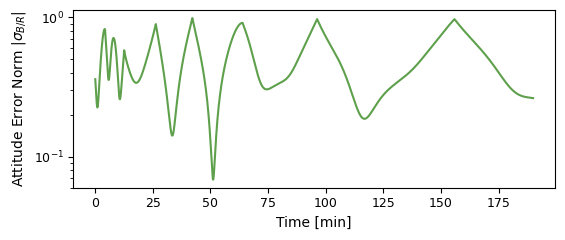

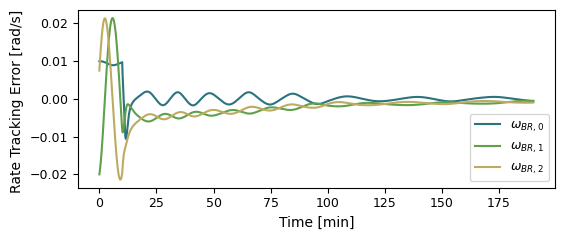

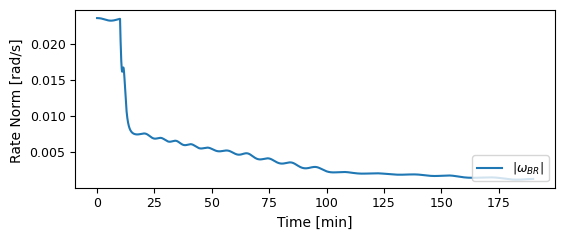

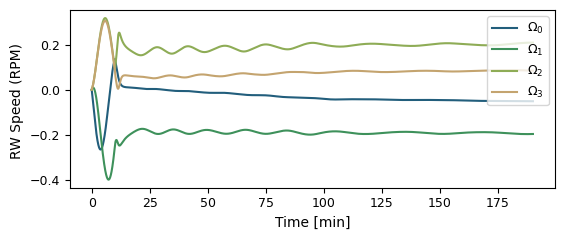

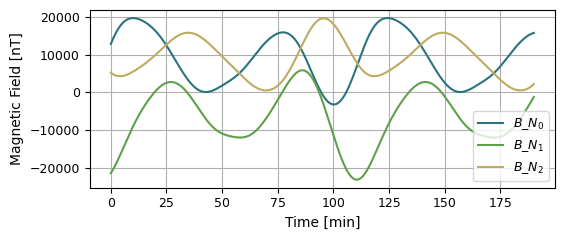

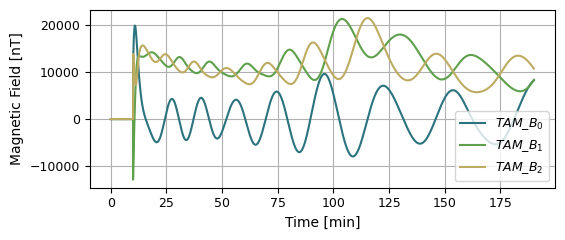

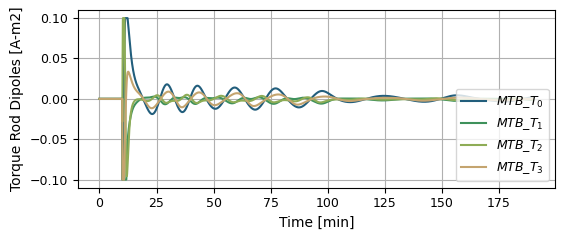

In [3]:

# Create your own scenario child class
class Scenario_mtb_detumble(Sim, Scenario):
    def __init__(self):
        super(Scenario_mtb_detumble, self).__init__()
        self.name = 'scenario_MtbDetumble'

        # declare additional class variables
        self.sNavTransName = "sNavTransMsg"
        self.attGuidName = "attGuidMsg"

        self.set_DynModel(cubesat_dynamics)
        self.set_FswModel(cubesat_fsw)

        self.configure_initial_conditions()
        self.log_outputs()

    def configure_initial_conditions(self):
        # Configure Dynamics initial conditions
        oe = orbitalMotion.ClassicElements()
        oe.a = 7800 * 1E3  # meters
        oe.e = 0.01
        oe.i = 33.3 * macros.D2R
        oe.Omega = 48.2 * macros.D2R
        oe.omega = 347.8 * macros.D2R
        oe.f = 85.3 * macros.D2R

        DynModels = self.get_DynModel()
        mu = DynModels.gravFactory.gravBodies['earth'].mu
        rN, vN = orbitalMotion.elem2rv(mu, oe)
        orbitalMotion.rv2elem(mu, rN, vN)
        DynModels.scObject.hub.r_CN_NInit = rN  # m   - r_CN_N
        DynModels.scObject.hub.v_CN_NInit = vN  # m/s - v_CN_N
        DynModels.scObject.hub.sigma_BNInit = [[0.1], [0.2], [-0.3]]  # sigma_CN_B
        DynModels.scObject.hub.omega_BN_BInit = [[0.01], [-0.02], [0.0075]]  # rad/s - omega_CN_B
    

    def log_outputs(self):
        FswModel = self.get_FswModel()
        DynModel = self.get_DynModel()
        samplingTime = FswModel.processTasksTimeStep
        
        self.scStateLog = DynModel.scObject.scStateOutMsg.recorder(samplingTime)
        self.magLog = DynModel.mag_field_module.envOutMsgs[0].recorder(samplingTime)
        self.tamCommLog = FswModel.tam_com_module.tamOutMsg.recorder(samplingTime)
        self.mtbDipoleCmdsLog = FswModel.mtbCmdMsg.recorder(samplingTime)

        self.AddModelToTask(DynModel.taskName, self.scStateLog)
        self.AddModelToTask(DynModel.taskName, self.magLog)
        self.AddModelToTask(DynModel.taskName, self.tamCommLog)
        self.AddModelToTask(DynModel.taskName, self.mtbDipoleCmdsLog)

        # To log the RW information, the following code is used:
        self.mrpLog = DynModel.rwStateEffector.rwSpeedOutMsg.recorder(samplingTime)
        self.AddModelToTask(DynModel.taskName, self.mrpLog)
        self.rwLogs = []
        for item in range(4):
            self.rwLogs.append(DynModel.rwStateEffector.rwOutMsgs[item].recorder(samplingTime))
            self.AddModelToTask(DynModel.taskName, self.rwLogs[item])

    def pull_outputs(self, show_plots):
        dataSigmaBN = np.delete(self.scStateLog.sigma_BN, 0, 0)
        dataOmegaBN = np.delete(self.scStateLog.omega_BN_B, 0, 0)
        dataOmegaRW = np.delete(self.mrpLog.wheelSpeeds, 0, 0)
        dataRW = []
        for i in range(4):
            dataRW.append(np.delete(self.rwLogs[i].u_current, 0, 0))
        dataMagField = np.delete(self.magLog.magField_N, 0, 0)
        dataTamComm = np.delete(self.tamCommLog.tam_B, 0, 0)
        dataMtbDipoleCmds = np.delete(self.mtbDipoleCmdsLog.mtbDipoleCmds, 0, 0)

        # Plot results
        plots.clear_all_plots()
        #   plot the results
        timeData = np.delete(self.scStateLog.times(), 0, 0) * macros.NANO2MIN

        figureList = {}
        plots.plot_attitude_error(timeData, dataSigmaBN)
        plots.plot_rate_error(timeData, dataOmegaBN)
        plots.plot_rate_norm(timeData, dataOmegaBN)
        plots.plot_rw_speeds(timeData, dataOmegaRW, 4)
        plots.plot_magnetic_field(timeData, dataMagField)
        plots.plot_data_tam_comm(timeData, dataTamComm)
        plots.plot_data_mtb_momentum_management(timeData, dataMtbDipoleCmds, self.get_DynModel().mtbConfigParams.numMTB)

        if show_plots:
            plots.show_all_plots()
        else:
            fileName = os.path.basename(os.path.splitext(__file__)[0])
            figureNames = ["attitudeErrorNorm", "rateError"]
            figureList = plots.save_all_plots(fileName, figureNames)

        return figureList


def runScenario(scenario):
    """method to initialize and execute the scenario"""
    simulationTime = macros.min2nano(60*3.)
    scenario.InitializeSimulation()

    # TODO : Request the mode we have just created
    scenario.modeRequest = "standby"
    scenario.ConfigureStopTime(macros.min2nano(10.))
    scenario.ExecuteSimulation()
    
    scenario.modeRequest = "mtb_detumble"
    scenario.ConfigureStopTime(macros.min2nano(60*3. + 10))
    scenario.ExecuteSimulation()
    
    return


def run(show_plots):
    scenario = Scenario_mtb_detumble()
    runScenario(scenario)
    figureList = scenario.pull_outputs(show_plots)
    return

run(True)